# Preprocessing

---
## Imports

In [30]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

from utils.duplicates import remove_rows, get_duplicates_to_delete, visualize_duplicates

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [31]:
df = pd.read_csv('../data/processed/csv/df.csv')
duplicates = pd.read_csv('../data/processed/csv/duplicates.csv')

--- 
## Remove duplicates

### Automatically delete:
- For each duplicate group, delete all but one rows marked as "Duplicate" for each "Style".
- Outputs "df_no_dup".

In [32]:
duplicates_to_delete = get_duplicates_to_delete(duplicates)
df_no_dup = remove_rows(df, duplicates_to_delete)
df_no_dup.head()

Identifying rows to delete...


100%|██████████| 5684/5684 [00:02<00:00, 2314.73it/s]

Removing rows...


,Path,Type,Width,Height,Ratio,Mode,Class,Style
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic


### Manually delete:
- Any rows marked as "Inspect" that belongs in the wrong "Class".
- Overwrite "df", as this DataFrame will continue to be used for further preprocessing.

In [33]:
inspects = duplicates[duplicates['Duplicate_Type'] == 'Inspect']
total_inspect_groups = inspects["Group"].nunique(dropna=False)
inspects

,Group,Duplicate_Type,Path,Type,Width,Height,Ratio,Mode,Class,Style,Hash
90,41,Inspect,tables/Craftsman/28467craftsman-dressers.jpg,jpg,350,350,1.0,RGB,tables,Craftsman,fbea6ebbd105a451cd78b1ccae23cb8492f195ae1d2312...
91,41,Inspect,beds/Craftsman/4866craftsman-bed.jpg,jpg,350,350,1.0,RGB,beds,Craftsman,fbea6ebbd105a451cd78b1ccae23cb8492f195ae1d2312...
153,72,Inspect,tables/Industrial/37555industrial-entertainmen...,jpg,350,350,1.0,RGB,tables,Industrial,d6aa7d5a82ad6a0068540af5ad5596af9055d02b93f41f...
154,72,Inspect,dressers/Industrial/dresser3452345.jpg,jpg,350,350,1.0,RGB,dressers,Industrial,d6aa7d5a82ad6a0068540af5ad5596af9055d02b93f41f...
205,98,Inspect,dressers/Farmhouse/34120farmhouse-buffets-and-...,jpg,350,350,1.0,RGB,dressers,Farmhouse,8bfa4afe3c256aadd100341fc042955a70b5cb41947de6...
206,98,Inspect,tables/Farmhouse/28763farmhouse-console-tables...,jpg,350,350,1.0,RGB,tables,Farmhouse,8bfa4afe3c256aadd100341fc042955a70b5cb41947de6...
227,109,Inspect,tables/Modern/10363modern-nightstands-and-beds...,jpg,350,350,1.0,RGB,tables,Modern,b3980ddb3c66d39bd098f3a70c182c66c39ff068c99734...
228,109,Inspect,lamps/Contemporary/4023contemporary-table-lamp...,jpg,350,350,1.0,RGB,lamps,Contemporary,b3980ddb3c66d39bd098f3a70c182c66c39ff068c99734...
235,113,Inspect,dressers/Modern/2146modern-dressers.jpg,jpg,350,350,1.0,RGB,dressers,Modern,f3bbad52dccc13b9cc659725921158ce2dd594a5931146...
236,113,Inspect,tables/Modern/11484modern-dressers.jpg,jpg,350,350,1.0,RGB,tables,Modern,f3bbad52dccc13b9cc659725921158ce2dd594a5931146...


In [34]:
# Delete one of each pair
# inspects_rows_to_delete = [91, 154, 205, 227, 235, 277, 280, 281, 287, 290, 299, 310, 318, 323, 325] 

# Only delete very different class ("tables" and "beds"). Similar classes are kept ("chairs" and "sofas")
# Assuming your DataFrame is named 'df'
inspects_rows_to_delete = ['beds/Craftsman/4866craftsman-bed.jpg', 'tables/Modern/10363modern-nightstands-and-bedside-tables.jpg']

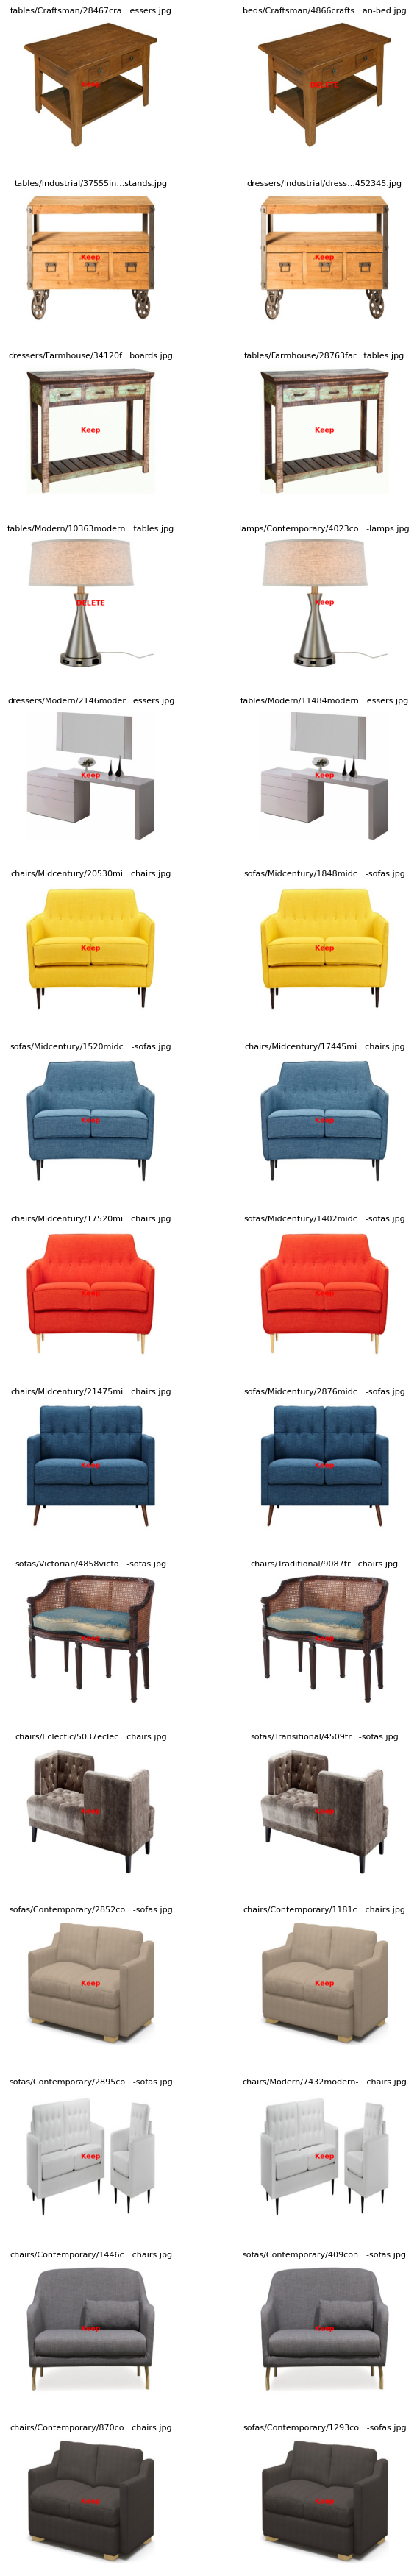

In [35]:
inspect_review = inspects.copy()
inspect_review["Duplicate_Type"] = "Keep"

inspect_review.loc[inspect_review['Path'].isin(inspects_rows_to_delete), "Duplicate_Type"] = "DELETE"
visualize_duplicates(inspect_review, total_inspect_groups)

In [36]:
inspects_to_delete = inspect_review[inspect_review["Duplicate_Type"] == "DELETE"]
inspects_to_delete

,Group,Duplicate_Type,Path,Type,Width,Height,Ratio,Mode,Class,Style,Hash
91,41,DELETE,beds/Craftsman/4866craftsman-bed.jpg,jpg,350,350,1.0,RGB,beds,Craftsman,fbea6ebbd105a451cd78b1ccae23cb8492f195ae1d2312...
227,109,DELETE,tables/Modern/10363modern-nightstands-and-beds...,jpg,350,350,1.0,RGB,tables,Modern,b3980ddb3c66d39bd098f3a70c182c66c39ff068c99734...


In [37]:
df = remove_rows(df, inspects_to_delete)
df.head()

Removing rows...


,Path,Type,Width,Height,Ratio,Mode,Class,Style
0,tables/Eclectic/4029eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
1,tables/Eclectic/4107eclectic-nightstands-and-b...,jpg,350,350,1.0,RGB,tables,Eclectic
2,tables/Eclectic/3885eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
3,tables/Eclectic/4040eclectic-side-tables-and-e...,jpg,350,350,1.0,RGB,tables,Eclectic
4,tables/Eclectic/4171eclectic-coffee-tables.jpg,jpg,350,350,1.0,RGB,tables,Eclectic


---
## Prepare DataFrame

- Mark duplicates images for augmentation later

In [38]:
# Merge the two DataFrames based on the "Path" column
merged_df = pd.merge(df, duplicates_to_delete[['Path']], on='Path', how='left', indicator=True)

# Create the "Duplicate_Type" column based on the merge indicator
merged_df['Duplicate_Type'] = merged_df['_merge'].map({'both': "Duplicate", 'left_only': "Unique"})

# Drop the merge indicator column
merged_df = merged_df.drop('_merge', axis=1)

# Update the original "df" with the new "Duplicate_Type" column
df = merged_df

---
## Split (train, validation, test)

In [39]:
train_data = df.copy()

train_X, test_X = train_test_split(
    train_data,
    test_size=0.2,
    random_state=42
)
train_X, val_X = train_test_split(
    train_X,
    test_size=0.25,
    random_state=42
)

print(f"Train: {train_X.shape[0]}\n"
      f"Validation: {val_X.shape[0]}\n"
      f"Test: {test_X.shape[0]}")

Train: 54048
Validation: 18017
Test: 18017


--- 
## Store

In [40]:
%store train_X
%store val_X
%store test_X

Stored 'train_X' (DataFrame)
Stored 'val_X' (DataFrame)
Stored 'test_X' (DataFrame)


---
## Guide for model notebooks

- Run this in the model notebooks, after using this code to import them.
``` %store -r train_X, val_X, test_X ```

- The following is done to images:
    - Resize to 256x256
    - Augment images marked as duplicates
    - Rescale pixel values and normalize
- Dataset with images and target labels are produced

Note: Using Tensorflow for quick normalization and rescaling. In 'utils/tensorflow_preprocessing.py' file, there is a functions to normalize and rescale the each image in the dataset.

In [41]:
# train_class_ds, class_encoder = prepare_image_target_dataset(train_X, target_name="Class")
# val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=class_encoder)
# test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=class_encoder)
# 
# train_style_ds, style_encoder = prepare_image_target_dataset(train_X, target_name="Class")
# val_style_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=style_encoder)
# test_style_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=style_encoder)
# 
# rec_ds = prepare_image_dataset(df_no_dup)